<a href="https://www.kaggle.com/shashank069/epl-player-pca-and-clustering?scriptVersionId=86844877" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/202122-epl-playerstats/2021-22_EPL_PlayerStats.csv


I collected data on premier league player performances for the current season(2021-22) from [fbref.com](http://https://fbref.com/en/). It consists of 83 different player metrics.The website data on many more metrics if you want to check them out. The idea is to use these metrics to bucket players according to their playing style. A generic way to do so would be to simply differentiate players according to their positions, however, that's not interesting. If at all you're a football fanatic and have been following the game for a while, you ought to be privy to the how often postitions in modern football overlap. Many full-backs engage extensively in attacks, often sacrificing defensive responsibilites, while central midfielders cover for them at the back. I want to see whether the clustering algorithm, based on these 83 metrics, can capture this trend.

PS: Check the dataset description if you want to know what these metrics are

In [2]:
df=pd.read_csv('../input/202122-epl-playerstats/2021-22_EPL_PlayerStats.csv',index_col=0)
df.sample(10,random_state=42)

,Rk,Player,Pos,MP,Starts,Min,90s,Gls,Ast,NPG,...,AttPenTouch,SuccDrib,AtmpDrib,Nutnegs,Carries,TotDistCarry,PrgDistCarry,CarryAtt3rd,Carry18Yd,CarryDIsp
457,396,Luke Shaw,DF,14,14,1179,13.1,0,1,0,...,10,5,12,0,587,3208,1953,37,1,10
257,196,Daniel James,FW,2,2,126,1.4,0,0,0,...,9,0,3,0,33,232,158,3,1,3
357,296,Tyrone Mings,DF,17,16,1479,16.4,1,1,1,...,34,4,5,0,457,2507,1204,7,0,2
532,471,Harry Winks,MF,7,4,365,4.1,0,0,0,...,3,2,4,0,224,1214,542,9,1,6
542,481,Kurt Zouma,DF,11,11,970,10.8,1,0,1,...,9,0,0,0,273,1556,791,4,0,0
77,78,Liam Cooper,DF,15,15,1274,14.2,0,1,0,...,9,3,3,0,612,3466,1996,2,0,2
132,133,Álvaro Fernández,GK,10,10,900,10.0,0,0,0,...,0,0,0,0,227,1036,631,0,0,0
76,77,Aaron Connolly,FW,4,1,156,1.7,0,0,0,...,4,0,1,0,22,131,40,0,0,1
84,85,Cucho,"FW,MF",14,6,656,7.3,2,1,2,...,20,16,25,0,211,1172,724,13,6,9
382,321,Andrew Omobamidele,DF,5,4,382,4.2,1,0,1,...,2,0,0,0,163,933,538,5,0,1


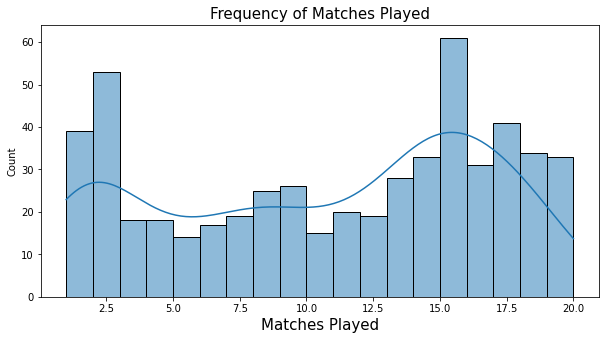

In [3]:
#Maximum games played by a player
plt.subplots(1,1,figsize=(10,5))
sns.histplot(df,x='MP',kde=True,binwidth=1)
plt.title('Frequency of Matches Played',size=15)
plt.xlabel('Matches Played',size=15)
plt.show()

As the data is from the current season till matchday-20, the maximum appearances by any player is 20. For the analysis, I am going to ignore players who have played less than 10 games. Also, if you notice in the dataframe above, few players have multiple postitions. I'll separate them into primary and secondary positions.

Few metrics are NULL for certain players and I'll replace them with 0.

In [4]:
df[df.isna().any(axis=1)].head(5)

,Rk,Player,Pos,MP,Starts,Min,90s,Gls,Ast,NPG,...,AttPenTouch,SuccDrib,AtmpDrib,Nutnegs,Carries,TotDistCarry,PrgDistCarry,CarryAtt3rd,Carry18Yd,CarryDIsp
17,18,Cameron Archer,"MF,FW",3,0,27,0.3,0,0,0,...,3,1,2,0,7,15,0,0,0,1
20,21,Kepa Arrizabalaga,GK,1,1,90,1.0,0,0,0,...,0,0,0,0,20,65,29,0,0,0
21,22,Harrison Ashby,DF,1,0,7,0.1,0,0,0,...,0,0,0,0,4,21,5,0,0,0
26,27,Daniel Bachmann,GK,10,10,900,10.0,0,0,0,...,0,1,1,0,153,840,540,0,0,0
29,30,Folarin Balogun,FW,2,1,70,0.8,0,0,0,...,6,0,2,0,16,50,16,0,1,2


In [5]:
df=df[df['MP']>10]
df['Primary_pos']=df['Pos'].str.split(',').str[0]
df['Secondary_pos']=df['Pos'].str.split(',').str[1]
df['Secondary_pos']=df['Secondary_pos'].fillna('NA')
df.drop(columns=['Pos'],inplace=True)
df=df.fillna(0)

# Checking for Correlation

In [6]:
tot=0
c=0
feats=df.columns[2:-2]
corr=df.iloc[:,2:-2].corr() # [2:-2] are the metric columns
for i,c1 in enumerate(corr.index):
    for j in range(i+1,len(corr)):
        if abs(corr.loc[c1,corr.columns[j]]) > 0.5: #cheecking whether correlation >0.5
            tot+=1
        c+=1
tot

687

From a total possible of 3403 unique variable pairs, 687 have an absolute correlation of more than 0.5. Hence, I'll use PCA to transform the variables and extract only the important information.

# PCA

In [7]:
#PCA
x=df.iloc[:,2:-2].values
x=StandardScaler().fit_transform(x)
pca=PCA()
pc=pca.fit_transform(x) #Matrix of principal components

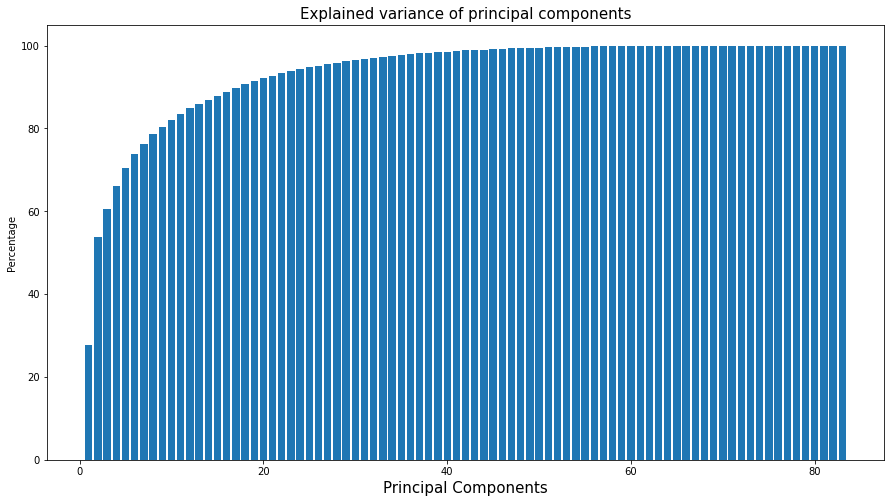

In [8]:
#Variance explained by each principal component
dic={}
s=0
for i,v in enumerate(pca.explained_variance_):
    s=s+v
    dic[i+1]=s*100/pca.explained_variance_.sum()
plt.subplots(1,1,figsize=(15,8))
plt.bar(dic.keys(),dic.values())
plt.title('Explained variance of principal components',size=15)
plt.xlabel('Principal Components',size=15)
plt.ylabel('Percentage')
plt.show()

The first 2 principal components(PCs) explain around 53% of the variation in data, while the first 5 PCs describe more than 70% of the variation. Clearly, there was no point in carrying all the 83 metrics. I'll consider only the first two
PCs going forward. Let's dig them up to see what information they relay.

# Relating principal components with original variables
PCs in isolation are neither fascinating nor intuitive unless one is able to compare them to the orginial variables. Essentially, each PC is a mixture (some linear combination) of the original variables, and it'd be useful to determine how much of each variable is present in a particular PC. How to do that? Well, some simple math will help with that.

Consider a data-space with n variables then the first principal component can be written as:
$$PC1=a_{11}X_{1}+a_{12}X_{2}+..+a_{1n}X_{n}$$
I won't deep-dive into the math behind PCA, but if you're familiar with it, you'd know that the vector $[a_{11}\,a_{12}\,a_{13}\,...a_{1n}]$ is the axis which explains the most variation in data and $\sum_{1}^{n}a_{1n}^{2}=1$. Now, as PC1 is a dot product of this vector and the data-space(x), the amount of a variable 'k' in PC1 can be ascertained by the coefficient $a_{1k}$. Essentially, you can think of these coefficients as the weights of the original variables in PC1. Let's see how this works in code.

In [9]:
axes=pca.components_ #Prinicpal axes (eignevectors) obtained from PCA
pc.T[0] #First principal component

array([-4.12602763e+00,  4.18118879e+00, -5.13479952e-01, -9.59175808e-03,
       -5.91242907e+00, -3.36444310e+00,  5.04691282e-01,  1.07715319e-01,
       -7.75467088e+00,  1.08687019e+01,  5.25106531e+00,  5.40240324e+00,
        2.55482127e+00, -2.73006435e+00,  1.02806521e+00,  3.66135279e+00,
       -5.16790543e+00,  4.68422929e+00,  4.79144137e+00,  7.31101408e-01,
       -3.55140435e+00,  7.70776395e+00,  5.49962564e+00, -1.88640948e+00,
        3.15247002e+00, -4.75279957e+00,  8.27083573e-01, -4.13989057e+00,
       -4.74852947e+00, -5.48058979e+00, -4.26182349e+00, -6.38047418e+00,
       -2.26961443e+00,  1.09261915e+00, -7.56794361e+00, -3.42778870e+00,
       -7.82536050e+00, -2.37914200e+00, -3.49506426e+00,  3.70674392e+00,
       -3.98578842e+00, -4.01420936e+00, -4.52273764e+00,  5.49439742e+00,
       -6.75046571e-01,  8.41940243e+00,  8.55828065e-01,  6.26546390e+00,
       -1.00622227e+01, -8.02436276e+00, -2.83059798e+00, -9.33836631e+00,
       -7.10357256e+00,  

The above first principal component can also be obtained by the dot product of x (original variables) and the first principal axis

In [10]:
#Function to extract top 10 variables in a PC
def feat_pc(axes,feats,n):
    ind=np.argsort(abs(axes[n]))[-10:]
    df=pd.DataFrame()
    df['variables']=feats[ind][::-1]
    df['coefficient']=axes[n][ind][::-1]
    df['percentage']=100*np.square(df['coefficient'])
    return df

Coefficients, as discussed above, are the weights of each variable. Negative coefficient implies a negative correlation of the variable with the PC. Percentage is calculated as the square of each coefficient times 100. Basically, the percentage of each variable in the PC.

# First Principal Component

In [11]:
#First principal component
feat_pc(axes,feats,0)

,variables,coefficient,percentage
0,npxG+xA/90,0.182421,3.327734
1,xG+xA/90,0.182066,3.314793
2,Def3rdTouch,-0.175862,3.092749
3,xG/90,0.169194,2.862662
4,npxG/90,0.168555,2.841083
5,npxG+xA,0.160451,2.574455
6,G+A/90,0.159336,2.538790
7,PrgDist,-0.156552,2.450864
8,npxG,0.153264,2.348987
9,xG,0.153050,2.342446


Evidently, the first PC is associated more with the goals and assists made by players. It's also negatively associated with touches in the defensive third. Hence,this component should help differntiate attacking and defensive players. Let's the same by performing clustering on just the first principal component

In [12]:
#Utility functions
def pos_infor(df,l,names=False):
    df['cl']=l
    for i in df['cl'].unique():
        print(i)
        print(df.groupby('cl').get_group(i)['Primary_pos'].value_counts())
        if names==True:
            print(df.groupby('cl').get_group(i)['Player'].head(20).values)
    df.drop(columns=['cl'],inplace=True)

def kmeans_scores(pc,ul,c1,c2=0):
    scores=[]
    for i in range(1,ul+1):
        kmeans=KMeans(i)
        if c2==0:
            kmeans.fit(pc.T[c1-1].reshape(-1,1))
        else:
            kmeans.fit(np.vstack((pc.T[c1-1],pc.T[c2-1])).T)
        scores.append(kmeans.inertia_)
    plt.plot(range(1,i+1),scores)
    plt.xlabel('Number of Clusters')
    plt.title('Elbow Method')
    plt.show()

def cluster_plot(pc,i,c1):
    kmeans=KMeans(i)
    l=kmeans.fit_predict(pc.T[c1-1].reshape(-1,1))
    plt.subplots(1,1,figsize=(14,6))
    sc=plt.scatter(np.arange(0,300),pc.T[c1-1],c=l)
    plt.xlabel('player index')
    plt.ylabel('PC'+str(c1))
    plt.show()
    return l

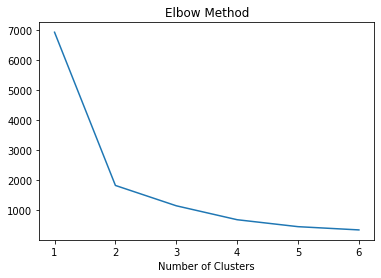

In [13]:
kmeans_scores(pc,6,1)

According to the above elbow plot, two clusters are sufficient for adequate grouping based on just the first principal component.

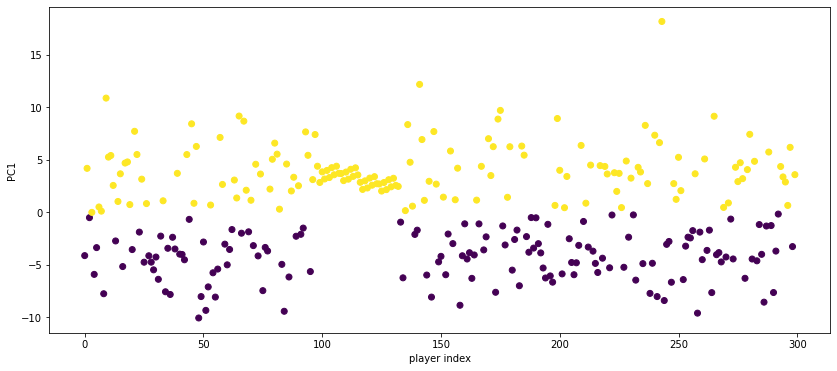

In [14]:
l=cluster_plot(pc,2,1)

The KMeans algorithm has clustered the data into groups based on negative and positive PC1 values. Let's now see the majority primary position of these clusters.

In [15]:
#Primary player positions in the above clusters
pos_infor(df,l)

0
DF    81
MF    48
GK    17
Name: Primary_pos, dtype: int64
1
FW    99
MF    46
DF     9
Name: Primary_pos, dtype: int64


Cluster '0' comprises mainly of defenders and all the goalkeepers, while cluster '1' has all the forward players and very few defenders. This division conforms with the variable composition of PC1 which we discussed above. As PC1 gives more weight to variables related to goals and assists, it helped differentiate between attacking and defensive players. It'll be interesting to know more about the 9 defenders belonging to cluster '1'. But first, let's repeat the exercise for some more principal components.

# Second Principal Component

In [16]:
#2nd principal component
feat_pc(axes,feats,1)

,variables,coefficient,percentage
0,SPA,0.186877,3.492317
1,Carries,0.183697,3.374476
2,TSPC,0.183113,3.353040
3,ProgPass,0.177562,3.152833
4,PressPass,0.172274,2.967840
5,Touches,0.171315,2.934873
6,TotDistCarry,0.169995,2.889820
7,Mid3rdTouch,0.168155,2.827612
8,SCPass,0.167813,2.816104
9,Att3rdTouch,0.164233,2.697256


You can check the data description to find what each of these variables track. SPA, for instance, is the the total short passes attempted. So, the second principal componet takes into account the type of passes made by the player.Carries, TotalDistCarry,ProgPass quantify how much a player is responsible in progressing the ball forward(toward's opposition half). SCPass are passes that create a shot. In essense, the second principal component relays information about the playing style of a player. It is correlated with players who make a lot of good passes and are involved heavily in teamplay.

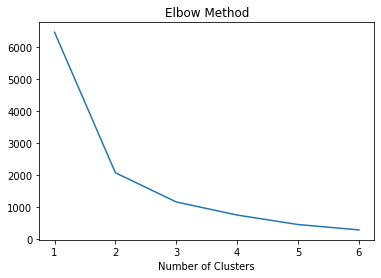

In [17]:
kmeans_scores(pc,6,2)

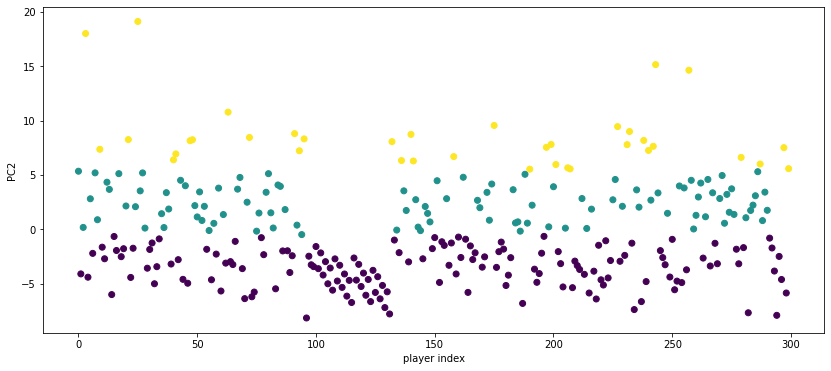

In [18]:
l=cluster_plot(pc,3,2)

The second principal component divides the data well into three clusters.

In [19]:
pos_infor(df,l,names=True)

1
DF    46
MF    37
FW    22
Name: Primary_pos, dtype: int64
['Max Aarons' 'Thiago Alcántara' 'Allan' 'Marcos Alonso'
 'Joachim Andersen' 'Jordan Ayew' 'César Azpilicueta' 'Saïd Benrahma'
 'Yves Bissouma' 'Emi Buendía' 'Sergi Canós' 'Matty Cash'
 'Timothy Castagne' 'Séamus Coleman' 'Liam Cooper' 'Vladimír Coufal'
 'Aaron Cresswell' 'Kevin De Bruyne' 'Emmanuel Dennis' 'Eric Dier']
0
FW    66
MF    41
DF    34
GK    17
Name: Primary_pos, dtype: int64
['Che Adams' 'Alisson' 'Miguel Almirón' 'Adam Armstrong'
 'Pierre-Emerick Aubameyang' 'Shandon Baptiste' 'Harvey Barnes'
 'Jan Bednarek' 'Christian Benteke' 'Jóhann Berg Guðmundsson'
 'Armando Broja' 'Josh Brownhill' 'Craig Cathcart' 'Trevoh Chalobah'
 'Andreas Christensen' 'Ciaran Clark' 'Tom Cleverley' 'Conor Coady'
 'Cucho' 'Craig Dawson']
2
MF    16
FW    11
DF    10
Name: Primary_pos, dtype: int64
['Trent Alexander-Arnold' 'Michail Antonio' 'Jarrod Bowen' 'João Cancelo'
 'Marc Cucurella' 'Stuart Dallas' 'Raphael Dias Belloli' 'Rúben Dia

Based on this component,the KMeans algorithm, I believe, has clustered players according to their creativity and ball progression actions. If you watch football, you'll recognize that players in cluster '0' make a lot of ball progression and are involved in a lot of teamplay in the attcking third. Contrarily, cluster '1' have rather immobile players who either solely score goals (forwards) or stick to their defensive duties. 

# Tenth Principal Componenet
Now, let's look at a PC that does not explain a lot of variation in data. PC 10 expalins only around 1.5% of the variation

In [20]:
feat_pc(axes,feats,10)

,variables,coefficient,percentage
0,LeftP,-0.402071,16.166134
1,RC,-0.327555,10.729214
2,PG,0.311456,9.700490
3,PA_x,0.296198,8.773297
4,DriblTkl%,0.284123,8.072569
5,YC,-0.265862,7.068271
6,RightP,0.262809,6.906879
7,TklAtt3rd,-0.193811,3.756281
8,GoalErrors,-0.178710,3.193721
9,ShotBlocks,0.142406,2.027934


From the variable compostition, it's not at all transparent what information this component relays. As opposed to the first two PCs which had majority contribution from similar variables, attacking output and passing types respectively, PC 10 is composed of many uncorrelated variables (Yellow cards, Goal errors and Left foot passes have little in common).

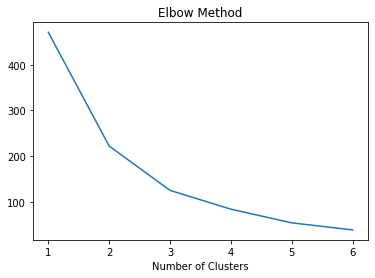

In [21]:
kmeans_scores(pc,6,9)

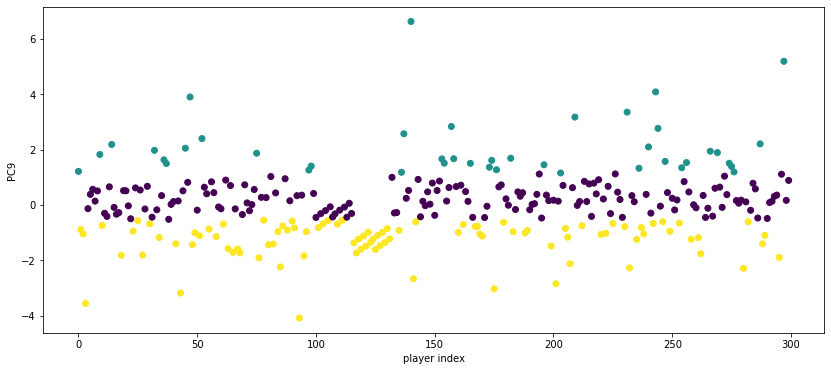

In [22]:
l=cluster_plot(pc,3,9)

Notice how the y range (range of principal component) has shrunk. It varied from -10 to 20 for PC2. This observation is in accordance with the PCA theory. As latter components explain less variation, the data-points are concentrated in a narrower range. This also results in inefficient clustering. The reduction in elbow score from a single cluster to 3 clusters is quite less compared to PC1 and PC2.

# Combining PC1 and PC2
Finally, let's see how the first two principal components, in combination, cluster the data.

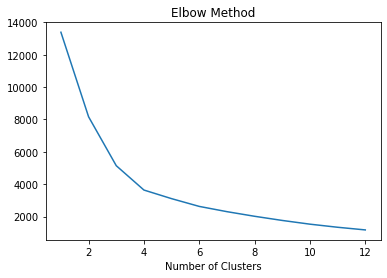

In [23]:
kmeans_scores(pc,12,1,2)

4 clusters seem to be the right choice here

In [24]:
kmeans=KMeans(4)
l=kmeans.fit_predict(pc[::,:2])
cen=kmeans.cluster_centers_
df['pc1']=pc.T[0]
df['pc2']=pc.T[1]
df['cluster']=l

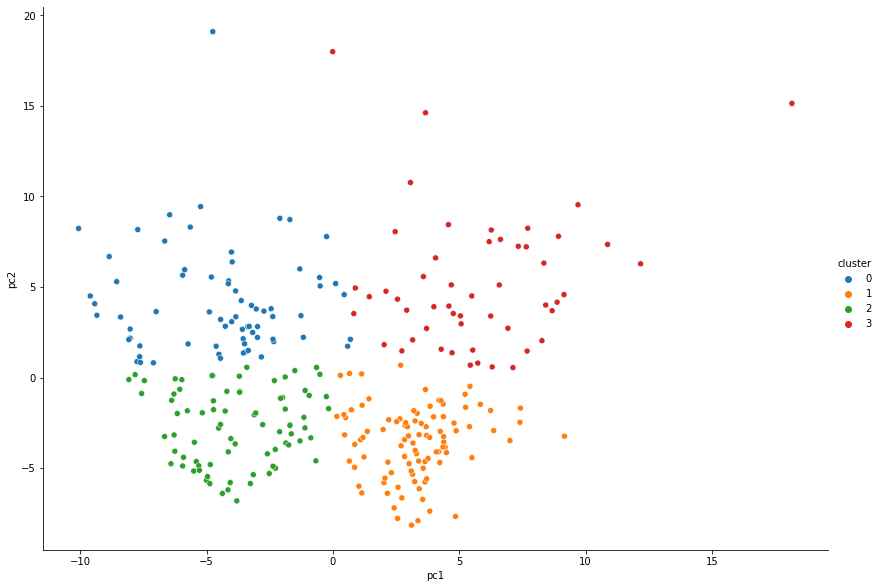

In [25]:
sns.relplot(data=df, x='pc1', y='pc2', hue='cluster', palette='tab10', kind='scatter',height=8.27, aspect=11.7/8.27)
plt.show()

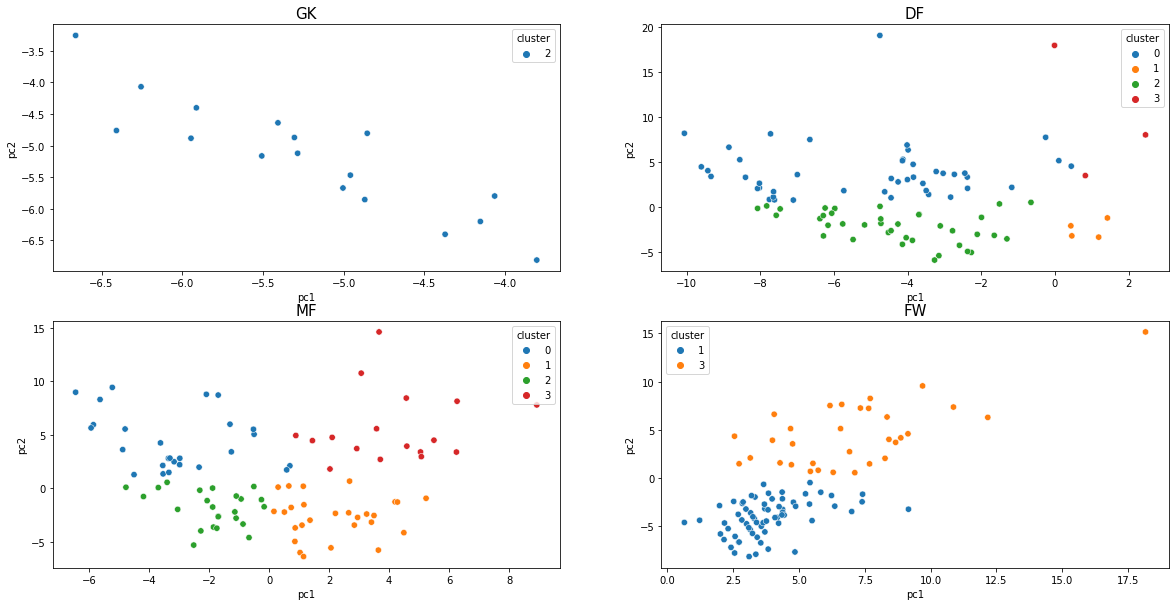

In [26]:
pos=[['GK','DF'],['MF','FW']]
f,ax=plt.subplots(2,2,figsize=(20,10))
for i in range(0,2):
    for j in range(0,2):
        r=df[df['Primary_pos']==pos[i][j]]
        sns.scatterplot(ax=ax[i,j],data=r, x='pc1', y='pc2', hue='cluster', palette='tab10',s=40)
        ax[i][j].set_title(pos[i][j],size=15)

Remember that PC1 is associated with attacking output (goals,assists etc) while PC2 is associated with ball progression and involvement in attacking third. Based on this, let's analyze the four clusters. Below, I have created a function to see the names belonging to each cluster.

**Cluster 0**
1. All players in this cluster have negative values for both PC1 and PC2
2. These are mainly defensive players. All goalkeepers, hence, quite undestandably belong to this cluster. Rest of this cluster comprises mainly of defenders, and a few midfilders who I believe must be the ones responsible for screening the back line.

**Cluster 1**
1. Positive values for both PC1 and PC2
2. This cluster mainly includes midfilders and forwards. There are only 3 defenders in this clusters. They must be the modern highly active full-backs who shuttle up and down the flank providing assistance in the attacking third. 
3. Players in this cluster are perhaps the cheif creators in their teams. Mohamed Salah, Trent, Bruno Fernandes etc fall in this cluster.

**Cluster 2**
1. Positive PC1 but negative PC2
2. These are players who have good attacking numbers (maybe not as good as the ones in cluster 1), but aren't involved a lot in the build up play in the attacking half. As it mainly includes forwards, I belive these are typical goalpoachers.

**Cluster 3**
1. Negative PC1 but postive PC2
2. Highly active players who cover a lot of distance and progress the ball, but don't have hight attacking numbers. Mainly composed of defenders and midfielders like Henderson,Fabinho, Declan Rice etc.

In [27]:
def player_cluster(pos,cl,df):
    db=df.groupby('cluster').get_group(cl)
    return db[db['Primary_pos']==pos]

In [28]:
db=player_cluster('MF',1,df)
db

,Rk,Player,MP,Starts,Min,90s,Gls,Ast,NPG,PG,...,TotDistCarry,PrgDistCarry,CarryAtt3rd,Carry18Yd,CarryDIsp,Primary_pos,Secondary_pos,pc1,pc2,cluster
11,12,Miguel Almirón,16,11,975,10.8,0,0,0,0,...,1926,928,11,4,23,MF,NA,0.504691,-2.211178,1
31,32,Shandon Baptiste,13,7,616,6.8,1,1,1,0,...,855,478,11,1,4,MF,NA,1.028065,-5.998870,1
41,42,Jóhann Berg Guðmundsson,17,13,1094,12.2,0,1,0,0,...,1666,814,16,5,17,MF,NA,0.731101,-1.782868,1
71,72,Tom Cleverley,13,9,726,8.1,0,2,0,0,...,595,257,3,2,8,MF,NA,1.092619,-3.434973,1
100,101,Ibrahima Diallo,13,5,595,6.6,0,1,0,0,...,998,486,7,0,6,MF,NA,0.855828,-4.956357,1
122,123,Mohamed Elyounoussi,14,10,906,10.1,2,0,2,0,...,1769,1002,24,4,25,MF,NA,2.650478,-2.279347,1
134,135,Fernandinho,12,5,520,5.8,1,1,1,0,...,1595,789,8,0,8,MF,NA,1.360160,-2.969801,1
144,145,Ryan Fraser,14,7,601,6.7,0,1,0,0,...,803,483,9,4,4,MF,NA,1.144641,-6.371473,1
153,154,Saman Ghoddos,11,2,349,3.9,1,1,1,0,...,612,384,7,2,2,MF,DF,3.639620,-5.767479,1
162,163,Anthony Gordon,15,8,791,8.8,2,1,2,0,...,1856,1022,15,7,13,MF,FW,2.206961,-2.331293,1
